In [2]:
%matplotlib inline   
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
LARGE_FIG_SIZE=(15, 15)

import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
import sys
sys.path.append('../')
from utils import utils

In [4]:
titanic = pd.read_csv('train.csv')
utils.nan_info(titanic)

,count,percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [6]:
titanic_non_null = titanic.dropna(subset=['Embarked'])
titanic_ft = titanic_non_null.drop('Survived', 1)
titanic_labels = titanic_non_null[['Survived']]
y = titanic_labels.values

In [7]:
from sklearn.tree import export_graphviz
def export_tree(feature_names):
    export_graphviz(
            tree_clf,
            out_file="titanic_tree.dot",
            feature_names=feature_names,
            class_names=['did not survive', 'survived'],
            rounded=True,
            filled=True
        )

# Features - Sex

In [8]:
enc = OrdinalEncoder()
X = enc.fit_transform(titanic_ft[['Sex']].values)
enc.categories_

[array(['female', 'male'], dtype=object)]

scores

precision 0.7403846153846154
recall    0.6794117647058824
f1        0.7085889570552146
accuracy  0.7862767154105736


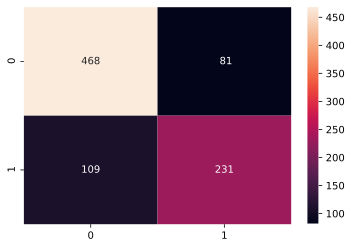

In [78]:
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

Predicting just on 'Sex' attribute results in classifying all females as Survived and males as did not survive.

74% of females survive and just 19% of males survive in the training examples. Based on this, the model outputs the probabilities of suriviving of every male to 0.19 and every female to 0.74. After this we make a decision to classify someone as survived if their probability >= 0.5.

In [58]:
all_fem_survived_all_males_did_not_survive = (~X[:,0].astype('bool')).astype('int64')
np.all(all_fem_survived_all_males_did_not_survive == y_pred)

True

In [85]:
export_tree(['Sex'])

![title](titanic_attr_sex.png)

# Features - Sex and Pclass

In [81]:
X = np.c_[enc.fit_transform(titanic_ft[['Sex']].values), titanic_ft['Pclass'].values]
X

array([[1., 3.],
       [0., 1.],
       [0., 3.],
       ...,
       [0., 3.],
       [1., 1.],
       [1., 3.]])

scores

precision 0.9464285714285714
recall    0.4676470588235294
f1        0.6259842519685039
accuracy  0.7862767154105736


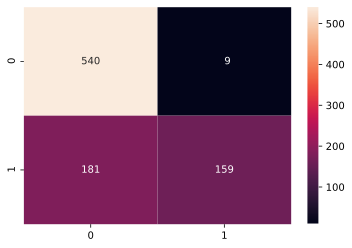

In [82]:
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

In [86]:
export_tree(['Sex', 'Fare'])

In [75]:
np.all(all_fem_survived_all_males_did_not_survive == y_pred)

True

Even with adding an extra feature of Pclass, probabiities of all males is less than 0.5, therefore classifying all males as "did not survive"

![titanic_attr_sex_fare.png](titanic_attr_sex_fare.png)

# Features - Sex and Fare

In [88]:
X = np.c_[enc.fit_transform(titanic_ft[['Sex']].values), titanic_ft['Fare'].values]
X

array([[ 1.    ,  7.25  ],
       [ 0.    , 71.2833],
       [ 0.    ,  7.925 ],
       ...,
       [ 0.    , 23.45  ],
       [ 1.    , 30.    ],
       [ 1.    ,  7.75  ]])

scores

precision 0.7620578778135049
recall    0.6970588235294117
f1        0.7281105990783411
accuracy  0.8008998875140607


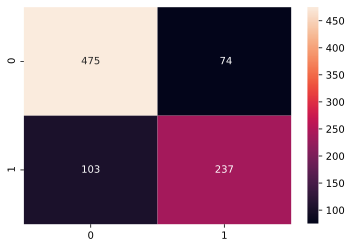

In [89]:
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

In [91]:
export_tree(['Sex','Fare'])

![title](titanic_d3.png)

![title](titanic_d4.png)

## Splitting Hairs - Overfitting

In males, if the fare is more than 26.269 and less than or equal to 26.469 then they survive!!!

In females, if the fare is more than 27.825 and less then or equal to 28.856 then they don't survive !!!

These kind of patterns do not generalize to the test set

# Categorizing the Fare attribute

Reduce the information in Fare attribute so that the model will not overfit but tries to find simple rules.

How to split the Fare attribute? 
- How many bins?
- Into equal bins? (pd.cut)
- select bins such that there are same number of data points in each bin, given number of bins? (pd.qcut)

In [92]:
fare_bins = pd.qcut(df['Fare'], q=8, labels=range(8))
X = np.c_[enc.fit_transform(titanic_ft[['Sex']].values), titanic_ft['Pclass'].values, fare_bins.values]
X

array([[1., 3., 0.],
       [0., 1., 7.],
       [0., 3., 2.],
       ...,
       [0., 3., 4.],
       [1., 1., 5.],
       [1., 3., 0.]])

scores

precision 0.7923875432525952
recall    0.6735294117647059
f1        0.7281399046104928
accuracy  0.8076490438695163
scores

precision 0.7984790874524715
recall    0.6176470588235294
f1        0.6965174129353234
accuracy  0.7941507311586051


DecisionTreeClassifier(max_depth=4)

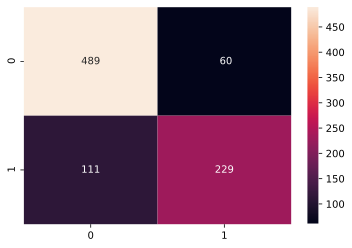

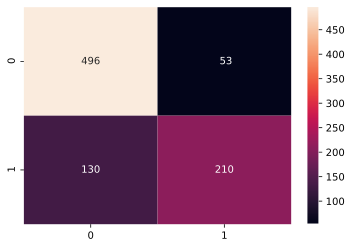

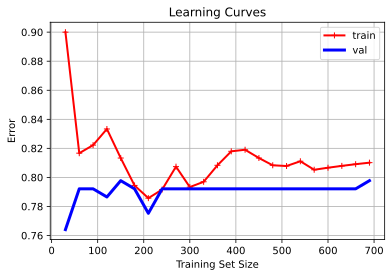

In [94]:
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

from sklearn.model_selection import cross_val_predict
y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=5, n_jobs=-1)
utils.show_scores(y.ravel(), y_cv_pred)

from sklearn.metrics import accuracy_score
utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
tree_clf.fit(X, y.ravel())

In [95]:
export_tree(['Sex','Class', 'Fare'])

![title](titanic_d3_fare_cat.png)

In [236]:
set(pd.qcut(df['Fare'], q=8))

{Interval(-0.001, 7.75, closed='right'),
 Interval(7.75, 7.896, closed='right'),
 Interval(7.896, 9.838, closed='right'),
 Interval(9.838, 14.454, closed='right'),
 Interval(14.454, 24.15, closed='right'),
 Interval(24.15, 31.0, closed='right'),
 Interval(31.0, 69.3, closed='right'),
 Interval(69.3, 512.329, closed='right')}

When the fares are binned like above, the model was
- able to identitfy females who survived (increased precision) (in 3rd class, when fare is more than 24.15 (4))
- sitll was not able to identify males who survived

accuracy on training set is 0.807 and accuracy on cross validation (kfold) is 0.794. This means that the model is not overfitting, but also not underfitting

Number of bins and choice of splitting can be tested and imporoved in hyperparameter tuning

# Features - Sex, Pclass, Age

Imputing age using KNNImputer rather than using median

In [96]:
drop_attr = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch']
num_attr = ['Age', 'Fare', 'Pclass'] #2
cat_ordinal_attr = ['Sex'] #1



pipeline = ColumnTransformer([
    ('cat_ordinal', OrdinalEncoder(), cat_ordinal_attr),
    ('num_pipeline', KNNImputer(), num_attr)
])


prepared_columns = cat_ordinal_attr + num_attr

df = pd.DataFrame(pipeline.fit_transform(titanic_ft), columns=prepared_columns)
df

In [97]:
df = pd.DataFrame(pipeline.fit_transform(titanic_ft), columns=prepared_columns)
df

,Sex,Age,Fare,Pclass
0,1.0,22.0,7.2500,3.0
1,0.0,38.0,71.2833,1.0
2,0.0,26.0,7.9250,3.0
3,0.0,35.0,53.1000,1.0
4,1.0,35.0,8.0500,3.0
...,...,...,...,...
884,1.0,27.0,13.0000,2.0
885,0.0,19.0,30.0000,1.0
886,0.0,27.8,23.4500,3.0
887,1.0,26.0,30.0000,1.0


In [98]:
# age_bins = pd.qcut(df['Fare'], q=8, labels=range(8))
X = np.c_[df['Sex'], df['Pclass'].values, df['Age'].values]
X

array([[ 1. ,  3. , 22. ],
       [ 0. ,  1. , 38. ],
       [ 0. ,  3. , 26. ],
       ...,
       [ 0. ,  3. , 27.8],
       [ 1. ,  1. , 26. ],
       [ 1. ,  3. , 32. ]])

scores

precision 0.7981366459627329
recall    0.7558823529411764
f1        0.7764350453172204
accuracy  0.8335208098987626
scores

precision 0.78125
recall    0.6617647058823529
f1        0.7165605095541402
accuracy  0.7997750281214848


DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)

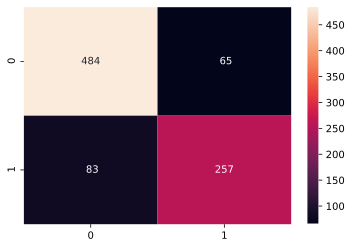

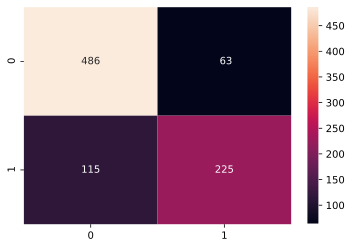

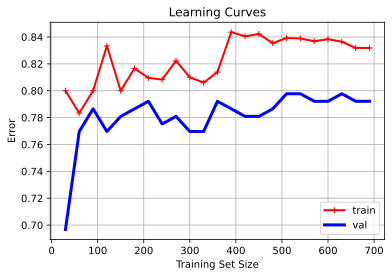

In [101]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

from sklearn.model_selection import cross_val_predict
y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=5, n_jobs=-1)
utils.show_scores(y.ravel(), y_cv_pred)

from sklearn.metrics import accuracy_score
utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
tree_clf.fit(X, y.ravel())

In [102]:
export_tree(['Sex','Class', 'Age'])

![title](titanic_age_cat.png)

Facing the same problem of overfitting even when regularized (max_depth, min_samples_leaf)

It was able to identify that males less than age 3.5 were survived. But, it also overfit for females (27.9<age<=31.05) as did not survive

## Categorizing the Age Attribute


In [131]:
age_bins = pd.cut(df['Age'], bins=[0,5,10,np.inf], labels=range(3))
X = np.c_[df['Sex'], df['Pclass'].values, age_bins.values]
X

array([[1., 3., 2.],
       [0., 1., 2.],
       [0., 3., 2.],
       ...,
       [0., 3., 2.],
       [1., 1., 2.],
       [1., 3., 2.]])

scores

precision 0.9326424870466321
recall    0.5294117647058824
f1        0.6754221388367729
accuracy  0.8053993250843644
scores

precision 0.7884615384615384
recall    0.6029411764705882
f1        0.6833333333333333
accuracy  0.7862767154105736


DecisionTreeClassifier(min_samples_leaf=5)

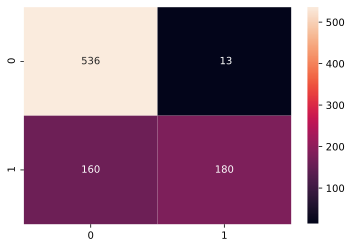

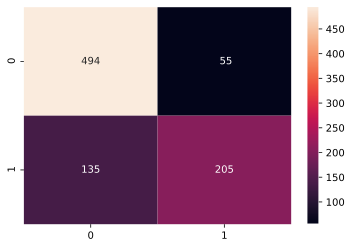

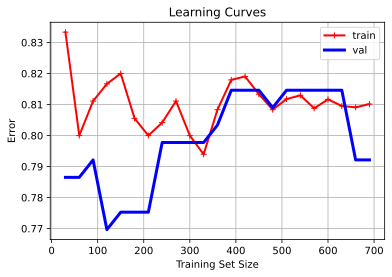

In [138]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(min_samples_leaf=5)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

from sklearn.model_selection import cross_val_predict
y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=5, n_jobs=-1)
utils.show_scores(y.ravel(), y_cv_pred)

from sklearn.metrics import accuracy_score
utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
tree_clf.fit(X, y.ravel())

In [135]:
export_tree(['Sex', 'Pclass', 'Age_cat'])

In [124]:
df['Survived'] = y.ravel()

![titanic_attr_sex_pclass_agecat.png](titanic_attr_sex_pclass_agecat.png)

The tree correctly found out that children survived, however cv score is 0.02 less than training score. I didn't understand why it would overfit 

# Parameters: Sex, Class, SipSp, Parch

In [139]:
enc = OrdinalEncoder()
foo = enc.fit_transform(titanic_ft[['Sex']].values)
enc.categories_

X = np.c_[foo, titanic_ft['Pclass'].values, titanic_ft['SibSp'].values + titanic_ft['Parch'].values]
X

array([[1., 3., 1.],
       [0., 1., 1.],
       [0., 3., 0.],
       ...,
       [0., 3., 3.],
       [1., 1., 0.],
       [1., 3., 0.]])

scores

precision 0.8
recall    0.6705882352941176
f1        0.7296
accuracy  0.8098987626546682
scores

precision 0.7591973244147158
recall    0.6676470588235294
f1        0.7104851330203442
accuracy  0.7919010123734533


DecisionTreeClassifier(min_samples_leaf=10)

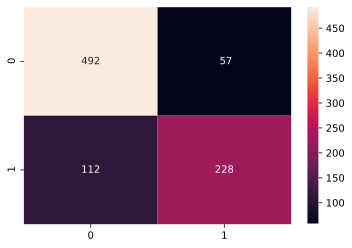

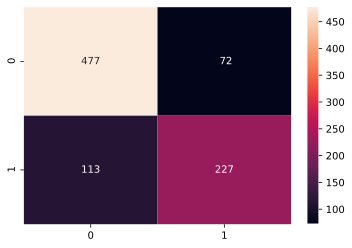

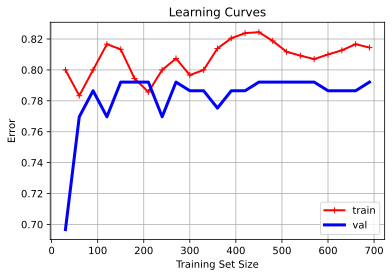

In [140]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(min_samples_leaf=10)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

from sklearn.model_selection import cross_val_predict
y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=5, n_jobs=-1)
utils.show_scores(y.ravel(), y_cv_pred)

from sklearn.metrics import accuracy_score
utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
tree_clf.fit(X, y.ravel())

In [141]:
export_tree(['Sex','Class', 'fam_size'])

![title](titanic_fam_size.png)

- Slightly improves over the (Sex + Class) attributes (all females survived and all males did not survive)
- females in 3rd class with family size more than 4 did not survive
- no improvements on the male side
- no overfitting

# Parameters: Sex, Class, Embarked

In [143]:
enc = OrdinalEncoder()
foo = enc.fit_transform(titanic_ft[['Sex']].values)
bar = enc.fit_transform(titanic_ft[['Embarked']].values)

X = np.c_[foo, titanic_ft['Pclass'].values, bar]
X

array([[1., 3., 2.],
       [0., 1., 0.],
       [0., 3., 2.],
       ...,
       [0., 3., 2.],
       [1., 1., 0.],
       [1., 3., 1.]])

scores

precision 0.8839285714285714
recall    0.5823529411764706
f1        0.7021276595744682
accuracy  0.8110236220472441
scores

precision 0.8839285714285714
recall    0.5823529411764706
f1        0.7021276595744682
accuracy  0.8110236220472441


DecisionTreeClassifier()

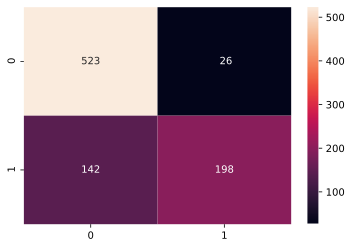

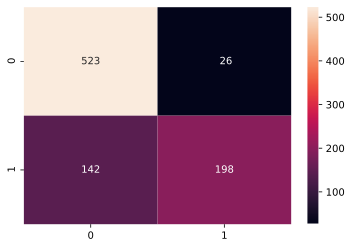

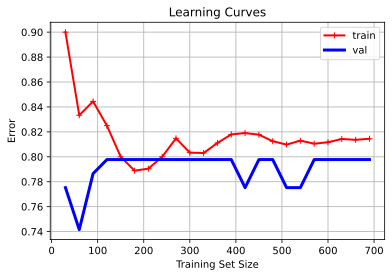

In [144]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

from sklearn.model_selection import cross_val_predict
y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=5, n_jobs=-1)
utils.show_scores(y.ravel(), y_cv_pred)

from sklearn.metrics import accuracy_score
utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
tree_clf.fit(X, y.ravel())

In [145]:
export_tree(['Sex','Class', 'Embarked'])

# Features - Combinations

In [8]:
drop_attr = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch']
num_attr = ['Age', 'Fare', 'Pclass'] #2
cat_ordinal_attr = ['Sex'] #1



pipeline = ColumnTransformer([
    ('cat_ordinal', OrdinalEncoder(), cat_ordinal_attr),
    ('num_pipeline', KNNImputer(), num_attr)
])


prepared_columns = cat_ordinal_attr + num_attr

df = pd.DataFrame(pipeline.fit_transform(titanic_ft), columns=prepared_columns)
df

,Sex,Age,Fare,Pclass
0,1.0,22.0,7.2500,3.0
1,0.0,38.0,71.2833,1.0
2,0.0,26.0,7.9250,3.0
3,0.0,35.0,53.1000,1.0
4,1.0,35.0,8.0500,3.0
...,...,...,...,...
884,1.0,27.0,13.0000,2.0
885,0.0,19.0,30.0000,1.0
886,0.0,27.8,23.4500,3.0
887,1.0,26.0,30.0000,1.0


In [1]:
enc = OrdinalEncoder()
foo = enc.fit_transform(titanic_ft[['Sex']].values)
bar = enc.fit_transform(titanic_ft[['Embarked']].values)
# fare_bins = pd.qcut(df['Fare'], q=8, labels=range(8))
# age_bins = pd.cut(df['Age'], bins=[0,5,10,np.inf], labels=range(3))

X = np.c_[foo, titanic_ft['Pclass'].values, bar,  titanic_ft['SibSp'].values + titanic_ft['Parch'].values, df['Fare'].values, df['Age'].values]
attrs = ['Sex', 'Pclass', 'Embarked', 'FamSize', 'Fare', 'Age']
# X = np.c_[foo, titanic_ft['Pclass'].values,  df['Fare'].values, df['Age'].values]
# attrs = ['Sex', 'Pclass', 'Fare', 'Age']
dft = titanic_non_null.reset_index(drop=True)
dft['Age'] = df['Age']
dft['Embarked'] = bar

NameError: name 'OrdinalEncoder' is not defined

scores

precision 0.8794326241134752
recall    0.7294117647058823
f1        0.7974276527331189
accuracy  0.8582677165354331


DecisionTreeClassifier(min_impurity_decrease=0.0005, min_samples_leaf=10)

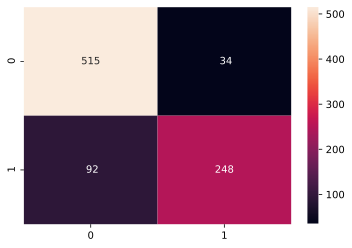

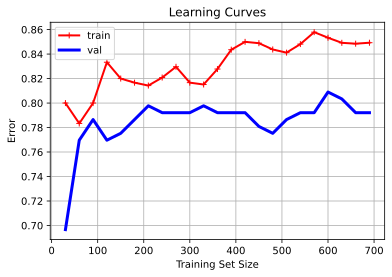

In [113]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(min_samples_leaf=10, min_impurity_decrease=0.0005)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

# from sklearn.model_selection import cross_val_predict
# y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=10, n_jobs=-1)
# utils.show_scores(y.ravel(), y_cv_pred)

from sklearn.metrics import accuracy_score
utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
tree_clf.fit(X, y.ravel())

In [114]:
export_tree(attrs)

![title](titanic_min_impurity_decrease_0.0045.png)

There is no need to categorize the attributes if we constrain min_impurity_decrease

scores

precision 0.9170731707317074
recall    0.6911764705882353
f1        0.7882599580712788
accuracy  0.8579465541490858
scores

precision 0.8
recall    0.5882352941176471
f1        0.6779661016949153
accuracy  0.7865168539325843


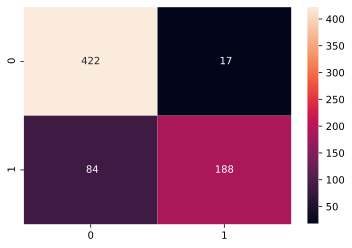

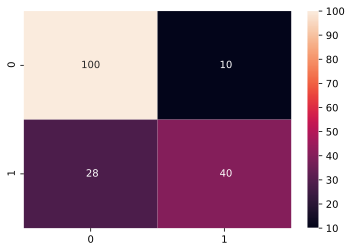

In [117]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = list(split.split(X, y))[0]
X_train, X_val, y_train, y_val = X[train_index], X[test_index], y[train_index], y[test_index]
tree_clf.fit(X_train, y_train)
y_train_predict = tree_clf.predict(X_train)
y_val_predict = tree_clf.predict(X_val)

utils.show_scores(y_train.ravel(), y_train_predict)
utils.show_scores(y_val.ravel(), y_val_predict)
export_tree(attrs)

In [121]:
150/178

0.8426966292134831

In [116]:
false_positives =(y_val.ravel() == 0) & (y_val_predict == 1)
false_negatives =(y_val.ravel() == 1) & (y_val_predict == 0)

fn=dft.loc[test_index].loc[false_negatives]
fn[(fn['Sex']=='male')&(fn['Pclass']==1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
369,371,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,0.0
736,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,0.0
598,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,0.0
680,682,1,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,0.0
644,646,1,1,"Harper, Mr. Henry Sleeper",male,48.0,1,0,PC 17572,76.7292,D33,0.0
549,551,1,1,"Thayer, Mr. John Borland Jr",male,17.0,0,2,17421,110.8833,C70,0.0
55,56,1,1,"Woolner, Mr. Hugh",male,49.4,0,0,19947,35.5000,C52,2.0
459,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,2.0
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,2.0
186,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,2.0


# Tuning RFC along with categorization hyperparameters

In [14]:
def plot_learning_curves(model, X, y, error, step_size=30):
  '''
  error / score function should be appropriate to the model and the problem
  - regression - RMSE
  - classification - sklearn.metrics.accuracy_score or sklearn.metrics.f1_score

  If score function,  an utility function (the higher the better) is used the graph is mirrored horizontally.
  '''
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  train_index, test_index = list(split.split(X, y))[0]
  X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  train_errors, val_errors = [], []
  for m in range(step_size, len(X_train), step_size):
      model.fit(X_train[:m], y_train[:m])
      y_train_predict = model.predict(X_train[:m])
      y_val_predict = model.predict(X_val)
      
      train_errors.append(error(y_train[:m], y_train_predict))
      val_errors.append(error(y_val, y_val_predict))
  plt.figure()    
  plt.plot(range(step_size, len(X_train), step_size), train_errors, "r-+", linewidth=2, label="train")
  plt.plot(range(step_size, len(X_train), step_size), val_errors, "b-", linewidth=3, label="val")
  plt.legend()
  plt.xlabel('Training Set Size')
  plt.ylabel('Error')
  plt.title('Learning Curves')
  plt.grid()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer

drop_attr = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age']
num_attr = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch'] #2
cat_ordinal_attr = ['Sex', 'Embarked'] #1



cat_pipeline = ColumnTransformer([
    ('cat_ordinal', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ord', OrdinalEncoder())]), cat_ordinal_attr),
    ('passthrough', 'passthrough', num_attr)
])

disc_pipeline = ColumnTransformer([
    ('fare', KBinsDiscretizer(strategy='quantile', encode='ordinal'), [3]),
    ('age', FunctionTransformer(lambda X: (pd.cut(X.ravel(), bins=[0,10,30,np.inf], labels=range(3))).to_numpy().reshape(-1,1)), [2])
], remainder='passthrough')


famsize_adder = ColumnTransformer([
    ('famsize_adder', FunctionTransformer(lambda X: np.array(X[:,0] + X[:,1]).reshape(-1,1)), [5,6])
], remainder='passthrough')

pipeline = Pipeline([
    ('cat_pipeline', cat_pipeline), #columns: Sex, 'Embarked', Age, Fare, Pclass, SibSp, Parch
    ('imputer', KNNImputer()),
    ('disc_pipeline', disc_pipeline), #columns: Fare, Age, Sex, 'Embarked', Pclass, SibSp, Parch
    ('famsize_adder', famsize_adder), #columns: fam_size, Fare, Age, Sex, 'Embarked', Pclass
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
])


prepared_columns = ['fam_size', 'Fare', 'Age', 'Sex', 'Embarked', 'Pclass']

In [380]:
# pipeline.set_params(cat_pipeline__fare_disc__n_bins=10)

In [9]:
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('cat_pipeline',
                 ColumnTransformer(transformers=[('cat_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Age', 'Fare', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('imputer', KNNImputer()),
                ('disc_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fare',
                                                  KBinsDiscretizer(encode='ordinal'),
                                                  [3]),
                                                 ('age',
                                                  FunctionTransformer(func=<function <lambda> at 0x123bfdee0>),
                                                  [2])])),
                ('famsize_adder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('famsize_adder',
                                                  FunctionTransformer(func=<function <lambda> at 0x123c0f550>),
                                                  [5, 6])])),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [674]:
# pd.DataFrame(pipeline.fit_transform(titanic_ft), columns=prepared_columns).describe()

In [29]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {
     'clf__n_estimators': [100], #100
     'clf__max_features': [4], 
     'clf__max_depth': [4], 
#      'clf__criterion': ["gini", "entropy"], #gini
     'clf__min_samples_split': [10],   
     'clf__min_samples_leaf': [4],
#      'clf__bootstrap': [True, False], #True
     'disc_pipeline__fare__n_bins': [10],
#         'disc_pipeline__age__n_bins': [10,12,14,16,18,20]
    },
]

clf = pipeline

model_rfc = GridSearchCV(clf, param_grid, cv=4, return_train_score=True, n_jobs=-1, verbose=1, refit=True)
model_rfc.fit(titanic_ft, y.ravel())
print(model_rfc.best_params_, max(model_rfc.cv_results_["mean_test_score"]))
cvres = model_rfc.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)
print('\n\n')
print(sorted([(x-y,y,p) for x,y,p in zip(cvres['mean_train_score'], cvres["mean_test_score"], cvres["params"])], key=lambda x:x[0])[0])

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'clf__max_depth': 4, 'clf__max_features': 4, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'disc_pipeline__fare__n_bins': 10} 0.8301569506726457



(0.011239355678683172, 0.8301569506726457, {'clf__max_depth': 4, 'clf__max_features': 4, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'disc_pipeline__fare__n_bins': 10})


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.9s finished


parameters with smallest difference between cv test and train

difference: 0.004863130184998399,
cv score: 0.8042863491293986,

{'clf__max_depth': 6,
  'clf__max_features': None,
  'clf__min_samples_leaf': 24,
  'clf__n_estimators': 100,
  'disc_pipeline__fare__n_bins': 8})

For this search grid
 ```
 'clf__n_estimators': [100], #100
 'clf__max_features': range(1,7), 
 'clf__max_depth': range(2,11,2), 
 'clf__min_samples_split': [2,5,10,20,40],   
 'clf__min_samples_leaf': range(4,25,4),
 'disc_pipeline__fare__n_bins': [4,8,10,20],
 ```
     

parameters that minimize difference between cv and train

differnce 0.0037336273688388655,

cv score 0.8076647275077768,
  ```
  'clf__max_depth': 4,
  'clf__max_features': 6,
  'clf__min_samples_leaf': 16,
  'clf__min_samples_split': 40,
  'clf__n_estimators': 100,
  'disc_pipeline__fare__n_bins': 4
  ```  
 
 
parameters that maximize cv

0.8301569506726457

```
'clf__max_depth': 4, 
'clf__max_features': 4, 
'clf__min_samples_leaf': 4, 
'clf__min_samples_split': 10, 
'clf__n_estimators': 100, 
'disc_pipeline__fare__n_bins': 10
```


In [794]:
[(i,y,p) for i,y,p in sorted([(x-y,y,p) for x,y,p in 
                            zip(cvres['mean_train_score'], cvres["mean_test_score"], cvres["params"])], key=lambda x:x[0])
 if i>0][0]

(0.0037336273688388655,
 0.8076647275077768,
 {'clf__max_depth': 4,
  'clf__max_features': 6,
  'clf__min_samples_leaf': 16,
  'clf__min_samples_split': 40,
  'clf__n_estimators': 100,
  'disc_pipeline__fare__n_bins': 4})

scores

precision 0.8586956521739131
recall    0.6970588235294117
f1        0.7694805194805194
accuracy  0.8402699662542182
scores

precision 0.8387096774193549
recall    0.6882352941176471
f1        0.7560581583198709
accuracy  0.8301462317210349


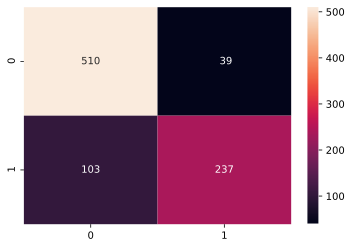

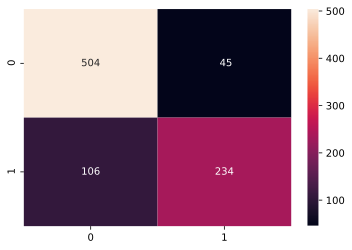

In [30]:
y_pred = model_rfc.best_estimator_.predict(titanic_ft)
utils.show_scores(y.ravel(), y_pred)

from sklearn.model_selection import cross_val_predict
y_cv_pred = cross_val_predict(model_rfc.best_estimator_, titanic_ft, y.ravel(), cv=4, n_jobs=-1)
utils.show_scores(y.ravel(), y_cv_pred)

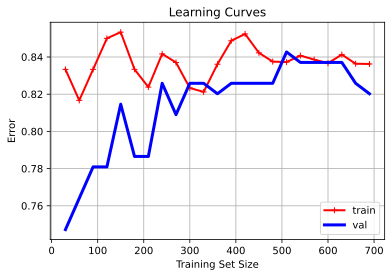

In [31]:
plot_learning_curves(model_rfc.best_estimator_, titanic_ft, y.ravel(), accuracy_score)

# Changing the classification Threshold

In [32]:
proba = model_rfc.best_estimator_.predict_proba(titanic_ft)
y_pred = model_rfc.best_estimator_.predict(titanic_ft)


[(0.8346456692913385, 0.5151515151515152),
 (0.8346456692913385, 0.5656565656565657),
 (0.8346456692913385, 0.5757575757575758),
 (0.8346456692913385, 0.5858585858585859),
 (0.8368953880764904, 0.5555555555555556),
 (0.8380202474690663, 0.5454545454545455),
 (0.8402699662542182, 0.5252525252525253),
 (0.8413948256467941, 0.5353535353535354)]

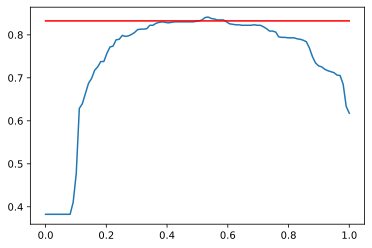

In [33]:
def accuracy_score_thresh(y, proba, thresh=0.5):
    y_pred = (proba[:,1]>=thresh).astype(np.int64)
    return accuracy_score(y, y_pred)

# accuracy_score_thresh(y, proba, 0.6), accuracy_score(y, y_pred)

thresh = np.linspace(0,1,100)

plt.plot(thresh, [accuracy_score_thresh(y, proba, t) for t in thresh])
plt.plot(thresh, [accuracy_score(y, y_pred) for t in thresh], 'r')

sorted([(accuracy_score_thresh(y, proba, t),t) for t in thresh if accuracy_score_thresh(y, proba, t)>accuracy_score(y, y_pred)])

scores

precision 0.8661087866108786
recall    0.6088235294117647
f1        0.7150259067357512
accuracy  0.8143982002249719
scores

precision 0.8291814946619217
recall    0.6852941176470588
f1        0.7504025764895331
accuracy  0.8256467941507312


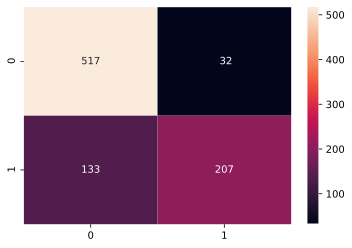

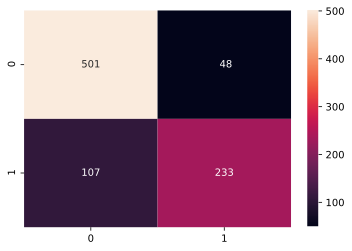

In [22]:
y_pred_new = (proba[:,1]>=0.434).astype(np.int64)

utils.show_scores(y.ravel(), y_pred)
utils.show_scores(y.ravel(), y_pred_new)

Increasing the threshold decreased the number of positively predicted examples, in doing it increased the accuracy.

- From the above plot, True positives reduced by 9 and False negatives increased by 9
- False positives decreased by 17 and True Negatives increased by 17

Accuracy increased because 17 examples which are above 0.5 prob, were removed, which are greater than 9 examples which are above 0.5 correctly classified.

# Preserving uncertainity while classifying

In [885]:
def random_pred(proba):
    preds = np.zeros((proba.shape[0],1))
    for i in range(proba.shape[0]):
        p = proba[i,:]
        preds[i] = np.random.choice([0,1], p=p)
    return preds.astype(np.int64)

(0.8323959505061868, 0.7266591676040495)

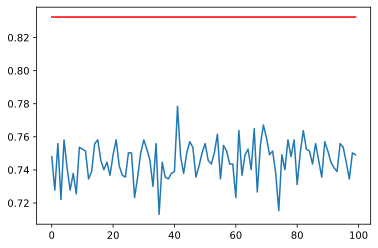

In [890]:
iterations = np.arange(100)
plt.plot(iterations, [accuracy_score(y.ravel(), random_pred(proba)) for i in iterations])
plt.plot(iterations, [accuracy_score(y, y_pred) for t in thresh], 'r')

# Tuning with just min_impurity_decrease

In [381]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer

drop_attr = ['PassengerId', 'Name', 'Ticket', 'Cabin','Embarked', 'SibSp', 'Parch']
num_attr = ['Age', 'Fare', 'Pclass','SibSp', 'Parch'] #2
cat_ordinal_attr = ['Sex'] #1



cat_pipeline = ColumnTransformer([
    ('cat_ordinal', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ord', OrdinalEncoder())]), cat_ordinal_attr),
    ('passthrough', 'passthrough', num_attr)
])


famsize_adder = ColumnTransformer([
    ('famsize_adder', FunctionTransformer(lambda X: np.array(X[:,0] + X[:,1]).reshape(-1,1)), [4,5])
], remainder='passthrough')

pipeline = Pipeline([
    ('cat_pipeline', cat_pipeline), #columns: Sex, Age, Fare, Pclass, SibSp, Parch
    ('imputer', KNNImputer()),
    ('famsize_adder', famsize_adder), #columns: fam_size, Sex, Fare, Age, Pclass
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
])


prepared_columns = ['FamSize','Sex', 'Age', 'Fare', 'Pclass']

In [380]:
# pd.DataFrame(pipeline.fit_transform(titanic_ft), columns=prepared_columns).describe()

,FamSize,Sex,Age,Fare,Pclass
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.906637,0.649044,29.878670,32.096681,2.311586
std,1.614703,0.477538,13.384526,49.697504,0.834700
min,0.000000,0.000000,0.420000,0.000000,1.000000
25%,0.000000,0.000000,22.000000,7.895800,2.000000
50%,0.000000,1.000000,29.000000,14.454200,3.000000
75%,1.000000,1.000000,37.000000,31.000000,3.000000
max,10.000000,1.000000,80.000000,512.329200,3.000000


In [395]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {
        'clf__n_estimators': [100],
        'clf__min_impurity_decrease': [i/10**j for i in range(1,9) for j in [3,4,5]],
        'clf__min_samples_leaf': [6,8,10]
    },
]



model_rfc = GridSearchCV(pipeline, param_grid, cv=4, return_train_score=True, n_jobs=-1, verbose=1, refit=True)
model_rfc.fit(titanic_ft, y.ravel())
print(model_rfc.best_params_, max(model_rfc.cv_results_["mean_test_score"]))
cvres = model_rfc.cv_results_

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s


{'clf__min_impurity_decrease': 1e-05, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 100} 0.8245717690784955


[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   18.0s finished


In [392]:
# for mean_score, test_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
#     print(mean_score, test_score, params['clf__min_impurity_decrease'], params['clf__min_samples_leaf'])

In [396]:
from scipy.stats import hmean
def custom_score(cv_score, train_score):
    s = 0.25/(0.3+np.abs(cv_score-train_score))
    return hmean((cv_score,s))


sorted([(custom_score(x,y),x,y,x-y,p) for x,y,p in zip(cvres['mean_train_score'], cvres["mean_test_score"], cvres["params"])], key=lambda x:x[0])[-1]

(0.8014809355036702,
 0.8357746802274538,
 0.8110532056720398,
 0.02472147455541407,
 {'clf__min_impurity_decrease': 0.005,
  'clf__min_samples_leaf': 8,
  'clf__n_estimators': 100})

In [398]:
pipeline.set_params(clf__n_estimators=300)
pipeline.set_params(clf__min_impurity_decrease=0.005)
pipeline.set_params(clf__min_samples_leaf=8)
pipeline.fit(titanic_ft, y.ravel())

Pipeline(steps=[('cat_pipeline',
                 ColumnTransformer(transformers=[('cat_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('passthrough', 'passthrough',
                                                  ['Age', 'Fare', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('imputer', KNNImputer()),
                ('famsize_adder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('famsize_adder',
                                                  FunctionTransformer(func=<function <lambda> at 0x1260eb040>),
                                                  [4, 5])])),
                ('clf',
                 RandomForestClassifier(min_impurity_decrease=0.005,
                                        min_samples_leaf=8, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

scores

precision 0.8251748251748252
recall    0.6941176470588235
f1        0.7539936102236422
accuracy  0.8267716535433071


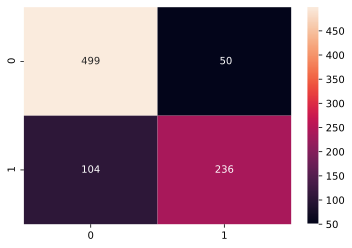

In [399]:
y_pred = pipeline.predict(titanic_ft)
utils.show_scores(y.ravel(), y_pred)

In [400]:
titanic_test = pd.read_csv('test.csv')
suffix = str(model_rfc.best_params_).replace('{','').replace('}','').replace("'",'').replace(': ','-')

In [401]:
y_test = pipeline.predict(titanic_test)
# Y_test_proba = model_rfc.best_estimator_.predict_proba(titanic_test)
# y_test = (Y_test_proba[:,1]>=0.535).astype(np.int64)

In [402]:
result_df = pd.DataFrame(y_test, index=titanic_test['PassengerId'], columns=['Survived'])
result_df.to_csv('result_8_0.005.csv')

https://stats.stackexchange.com/questions/312119/reduce-classification-probability-threshold


https://www.fharrell.com/post/classification/

https://stats.stackexchange.com/questions/405041/philosophical-question-on-logistic-regression-why-isnt-the-optimal-threshold-v?noredirect=1&lq=1

https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/